In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### EC3D dataset
For the analysis EC3D dataset was used. Here is it's overview:

| Exercise                   | Instruction label | Sub1 | Sub2 | Sub3 | Sub4 | Total |
|-----------------------------------|-------------------|------|------|------|------|-------|
| Squats                       | Correct           | 10   | 10   | 11   | 10   | 41 |
|                              | Feet too wide     | 5    | 8    | 5    | 5    | 23    |
|                              | Knees inward      | 6    | 7    | 5    | 5    | 23    |
|                              | Not low enough    | 5    | 7    | 5    | 4    | 21    |
|                              | Front bent        | 5    | 6    | 6    | 7    | 24    |
| Lunges                       | Correct              | 12   | 11   | 11   | 12   | 46    |
|                              | Not low enough    | 10   | 10   | 10   | 10   | 40    |
|                              | Knee passes toe   | 10   | 10   | 11   | 10   | 41    |
| Planks                       | Correct               | 7    | 8    | 11   | 7    | 33    |
|                              | Arched back       | 5    | 5    | 11   | 9    | 30    |
|                              | Hunch back        | 10   | 10   | 11   | 9    | 40    |


In [3]:
LABELS_COLUMNS = ["exercise", "subject", "label", "rep", "frame"]

In [4]:
dataset = pd.read_pickle("../data/data_3D.pickle")

exercises = dataset["poses"]

labels_df = pd.DataFrame(dataset["labels"], columns=LABELS_COLUMNS)
labels_df["frame"] = np.arange(len(labels_df))
labels_df[LABELS_COLUMNS[2:]] = labels_df[LABELS_COLUMNS[2:]].astype("int")

In [37]:
x = labels_df[labels_df["exercise"] == "Plank"]
for _, person in x[x["label"] == 8].groupby("subject"):
    print(person["rep"].unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11]
[ 2  3  4  5  6  7  8  9 10]


### Dataset processing

To prepare data for deep models we need to keep only label and positions in time for each exercise.


In [5]:
def get_rep_frames_from_df(df: pd.DataFrame) -> pd.Grouper:
    groups = df.groupby("subject")

    return [
        rep["frame"].values
        for _, subject_group in groups
        for _, rep in subject_group.groupby("rep")
    ]


def get_df_from_frames(
    df: pd.DataFrame, exercises: np.ndarray, label: int
) -> pd.DataFrame:
    frames = get_rep_frames_from_df(df)
    final_reps_df = pd.DataFrame()
    for rep_num, frames_rep in enumerate(frames, start=1):
        rep_3d_joints = exercises[frames_rep]

        rep_3d_joints_x = rep_3d_joints[:, 0, :].reshape(-1)
        rep_3d_joints_y = rep_3d_joints[:, 1, :].reshape(-1)
        rep_3d_joints_z = rep_3d_joints[:, 2, :].reshape(-1)
        frames_num = len(rep_3d_joints_x) // 25

        final_rep = np.array(
            [
                np.full_like(rep_3d_joints_x, rep_num, dtype=int),
                rep_3d_joints_x,
                rep_3d_joints_y,
                rep_3d_joints_z,
                np.repeat(np.arange(frames_num, dtype=int), 25),
                np.full_like(rep_3d_joints_x, label, dtype=int),
            ]
        ).T
        final_reps_df = pd.concat(
            [
                final_reps_df,
                pd.DataFrame(
                    final_rep, columns=["rep", "x", "y", "z", "frame", "label"]
                ),
            ],
            axis=0,
        )

    final_reps_df["rep"] = final_reps_df["rep"].astype("int")
    final_reps_df["frame"] = final_reps_df["frame"].astype("int")
    final_reps_df["label"] = final_reps_df["label"].astype("int")

    return final_reps_df

### Squat

In [6]:
squat_df = labels_df[labels_df["exercise"] == "SQUAT"]

correct_squat_df = squat_df[squat_df["label"] == 1]
feet_too_wide_squat_df = squat_df[squat_df["label"] == 2]
knees_inwards_squat_df = squat_df[squat_df["label"] == 3]
not_low_enough_squat_df = squat_df[squat_df["label"] == 4]
front_bend_squat_df = squat_df[squat_df["label"] == 5]

In [7]:
get_df_from_frames(correct_squat_df, exercises, label=1).to_csv(
    "../data/squat/correct.csv", index=False
)
get_df_from_frames(feet_too_wide_squat_df, exercises, label=2).to_csv(
    "../data/squat/feet_to_wide.csv", index=False
)
get_df_from_frames(knees_inwards_squat_df, exercises, label=3).to_csv(
    "../data/squat/knees_inwards.csv", index=False
)
get_df_from_frames(not_low_enough_squat_df, exercises, label=4).to_csv(
    "../data/squat/not_low_enough.csv", index=False
)
get_df_from_frames(front_bend_squat_df, exercises, label=5).to_csv(
    "../data/squat/front_bend.csv", index=False
)

### Lunges

In [8]:
lunges_df = labels_df[labels_df["exercise"] == "Lunges"]

correct_lunges_df = lunges_df[lunges_df["label"] == 1]
not_low_enough_lunges_df = lunges_df[lunges_df["label"] == 6]
knee_passes_toe_lunges_df = lunges_df[lunges_df["label"] == 4]

In [9]:
get_df_from_frames(correct_lunges_df, exercises, label=1).to_csv(
    "../data/lunges/correct.csv", index=False
)
get_df_from_frames(not_low_enough_lunges_df, exercises, label=2).to_csv(
    "../data/lunges/not_low_enough.csv", index=False
)
get_df_from_frames(knee_passes_toe_lunges_df, exercises, label=3).to_csv(
    "../data/lunges/knee_passes_toe.csv", index=False
)

### Planks

In [10]:
planks_df = labels_df[labels_df["exercise"] == "Plank"]

correct_planks_df = planks_df[planks_df["label"] == 1]
arched_back_planks_df = planks_df[planks_df["label"] == 7]
hunch_back_planks_df = planks_df[planks_df["label"] == 8]

In [11]:
get_df_from_frames(correct_planks_df, exercises, label=1).to_csv(
    "../data/plank/correct.csv", index=False
)
get_df_from_frames(arched_back_planks_df, exercises, label=2).to_csv(
    "../data/plank/arched_back.csv", index=False
)
get_df_from_frames(hunch_back_planks_df, exercises, label=3).to_csv(
    "../data/plank/hunch_back.csv", index=False
)

### Visualization 

In [12]:
openpose_connections = [
    (0, 1),
    (1, 2),
    (1, 5),
    (1, 8),
    (2, 3),
    (3, 4),
    (5, 6),
    (6, 7),
    (8, 9),
    (9, 10),
    (10, 11),
    (8, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (0, 16),
    (15, 17),
    (16, 18),
    (17, 18),
    (11, 24),
    (11, 22),
    (22, 23),
    (14, 21),
    (14, 19),
    (19, 20),
]
correct_squat_df = pd.read_csv("../data/squat/correct.csv")
correct_squat_1_rep_df = correct_squat_df[correct_squat_df["rep"] == 1]

In [13]:
X_LIM = (-1, 1)
Y_LIM = (-1, 1)
Z_LIM = (-1, 1)

ELEV = 0
AZIM = 0

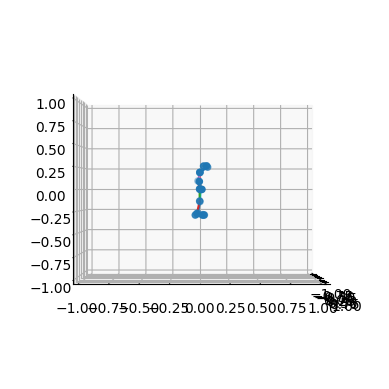

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML


def get_3D_animation(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    def update(i):
        ax.clear()
        ax.set_xlim3d(*X_LIM)
        ax.set_ylim3d(*Y_LIM)
        ax.set_zlim3d(*Z_LIM)
        ax.view_init(elev=ELEV, azim=AZIM)

        frame_data = data[data["frame"] == i]
        ax.scatter3D(frame_data["x"], frame_data["y"], frame_data["z"])
        frame_data = frame_data.reset_index()

        for start, stop in openpose_connections:
            ax.plot(
                xs=[frame_data.loc[start]["x"], frame_data.loc[stop]["x"]],
                ys=[frame_data.loc[start]["y"], frame_data.loc[stop]["y"]],
                zs=[frame_data.loc[start]["z"], frame_data.loc[stop]["z"]],
            )

    return animation.FuncAnimation(
        fig, update, frames=pd.unique(data["frame"]), interval=120
    )


ani = get_3D_animation(correct_squat_1_rep_df)
HTML(ani.to_jshtml())